In [23]:
!git clone https://github.com/Antonomaz/Corpus.git 2> nul || cd Corpus && git pull

Already up to date.


In [24]:
from bs4 import BeautifulSoup
from pprint import pprint
from glob import glob
import json
from numpy import mean, std, amax, amin
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from collections import Counter
from pprint import pprint
import xmltodict
import contextlib


In [25]:
with open("LGERM.json", encoding="utf-8") as f:
    LGERM = json.load(f)
mots_LGERM = set(LGERM)

path = "Corpus/Mazarinades/*/*.xml"

files = glob(path)

print(len(files))

3065


In [26]:
def ttr(chaine):
    chaine = chaine.split()
    return len([word for word in chaine if word in mots_LGERM])/len(chaine)

def tok_voc_ratio(str_):
    if not str_:
        return
    lstr = str_.split()
    return len(set(lstr))/len(lstr)

def compte_hapax(str):
    ct = Counter(str)
    return len([val for val in ct.values() if val == 1])

def eval_sub_type(str_):
    if str_ == "no":
        return False
    elif str_ == "yes":
        return True
    else:
        return str_


Distribution mots outils

OCR performance prediction using cross-OCR
alignment
Ahmed BEN SALAH*, Jean philippe MOREUXt
, Nicolas RAGOT+ and Thierry PAQUET§

https://dl.acm.org/doi/pdf/10.1145/2595188.2595221


In [27]:

dict_stats = {}

from random import sample

files = sample(files, 1000)

for i, file in enumerate(tqdm(files)):
    with open(file, encoding="utf-8") as f:
        txt = f.read()


    dict_ = xmltodict.parse(txt)
    dict_ = dict_["TEI"]["teiHeader"]
    header = dict_["profileDesc"]["textClass"]["keywords"]["term"]
    header = [{header["@type"] : header["#text"] if "#text" in header else eval_sub_type(header["@subtype"]) if "@subtype" in header else None} for header in header]

    dict_header = {}
    for dicts in header:
        for k, v in dicts.items():
            if k not in dict_header:
                dict_header[k] = []
            dict_header[k].append(v)

    dict_header = {k : v if len(v) > 1 else v[0] for k, v in dict_header.items()}

    with contextlib.suppress(KeyError):
        creation = dict_["profileDesc"]["settingDesc"]["setting"]["date"]
        if creation is None:
            dict_header["creation"] = "00-00-0000"
        else:
            dict_header["creation"] = creation["@when"] if "@when" in creation else creation["#text"]

    dict_header["change"] = dict_["revisionDesc"]["change"]

    titre = dict_["fileDesc"]["titleStmt"]["title"]
    titre = [e for e in titre if e["@type"] == "main"][0]["#text"]
    dict_header["titre"] = titre if isinstance(titre, str) else " ".join(titre)

    dict_header["dates"] = dict_["fileDesc"]["publicationStmt"]["date"]



    tei_head = re.search(r"<teiHeader>.*?</teiHeader>", txt, re.DOTALL).group()

    soup = BeautifulSoup(tei_head, "html.parser")

    elts = {
        e.tag: e.text
        for e in soup.find_all()
    }


    txt = re.split(r"(?:<pb .*?>)", txt)[1:]
    txt = [re.split(r"\n|<lb/>|<l>", line) for line in txt]
    txt = [[re.sub(r"<.*?>|  |\t", "", line) for line in page] for page in txt]
    txt = [[line for line in page if line.strip()] for page in txt]
    txt = [page for page in txt if page]

    pages = [' '.join(line for line in page) for page in txt]

    plain = ' '.join(mot for page in txt for line in page for mot in line)

    if not txt:
        print(f"Empty file: {file}, {i = }")
        continue

    dict_stats[file] = {
        "pages": len(txt),
        "lines": sum(len(page) for page in txt),
        "words": sum(len(line.split()) for page in txt for line in page),
        "chars": sum(len(line) for page in txt for line in page),
        "ttr": ttr(plain),
        "tok_voc_ratio": tok_voc_ratio(plain),
        "hapax": compte_hapax(plain),
        "hapax_ratio": compte_hapax(plain)/len(plain.split()),
        "ttrs": [ttr(page) for page in pages],
        "header": dict_header,
    }


  0%|          | 0/1000 [00:00<?, ?it/s]

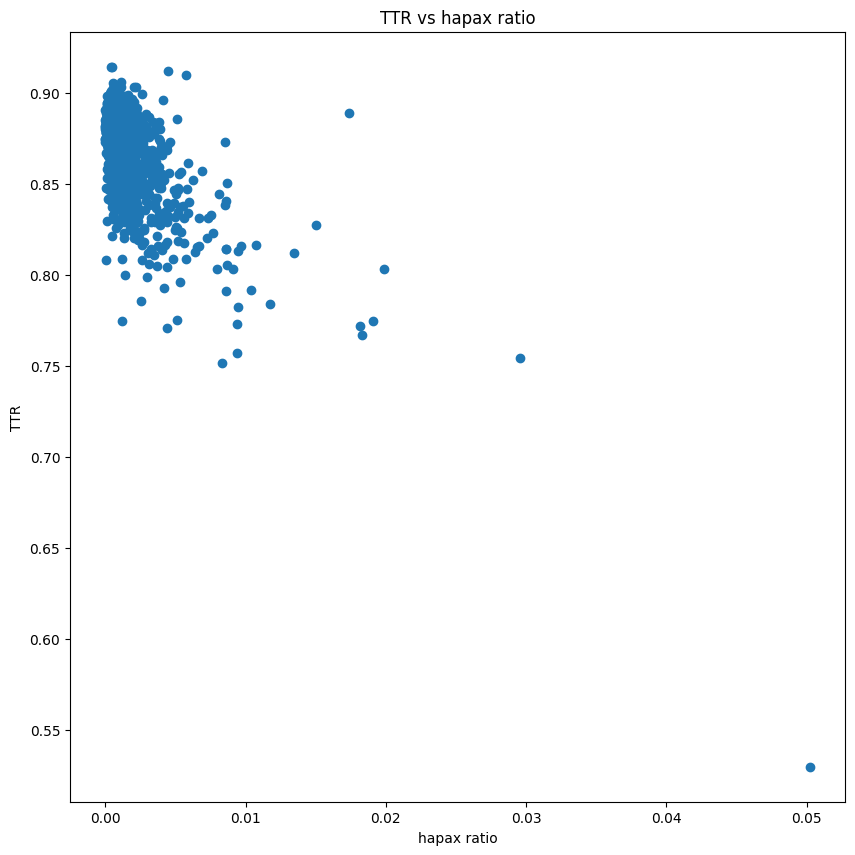

In [28]:
tup = [(val["hapax_ratio"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs hapax ratio")
plt.xlabel("hapax ratio")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))

plt.show()

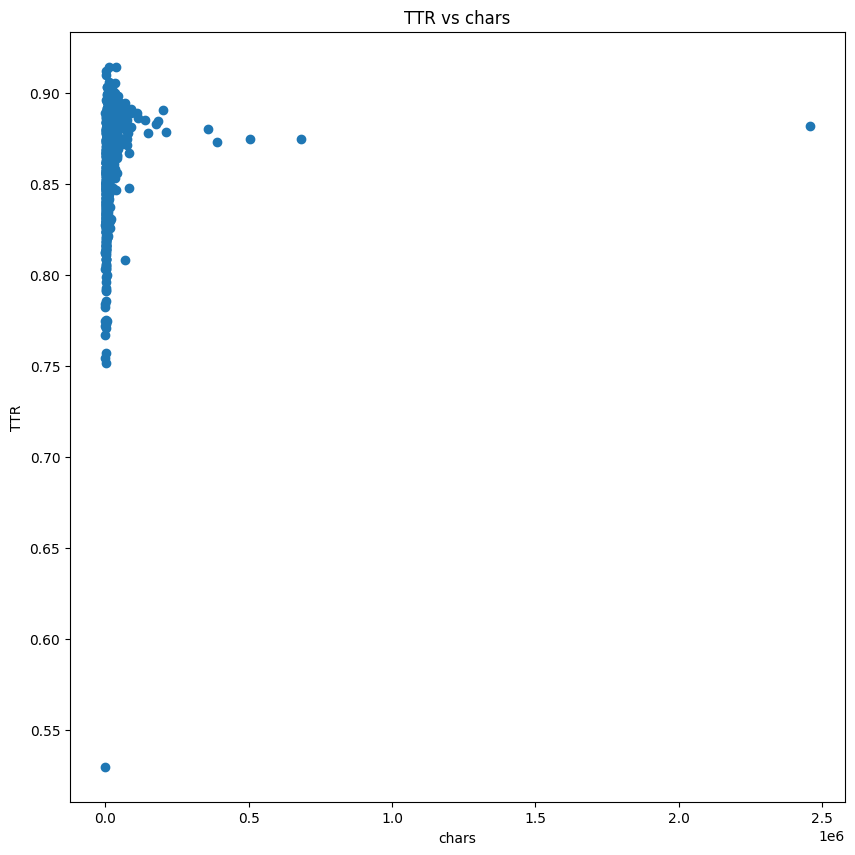

In [29]:
tup = [(val["chars"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs chars")
plt.xlabel("chars")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))


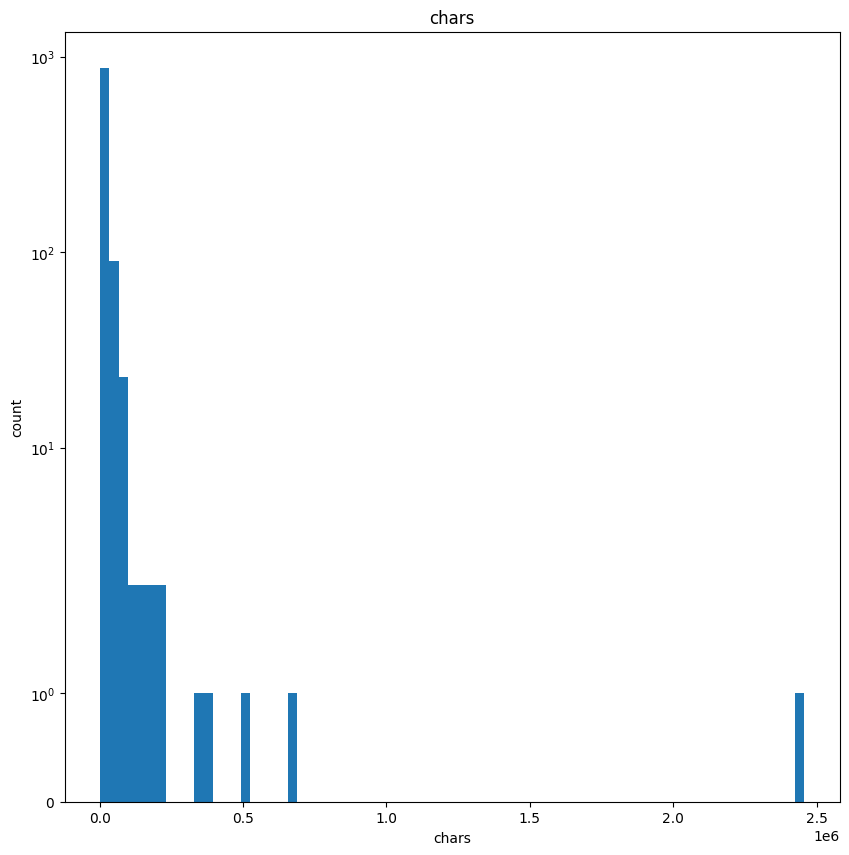

In [30]:
x = [v["chars"] for v in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("chars")
plt.xlabel("chars")
plt.ylabel("count")
plt.xscale('linear')
plt.yscale('symlog', linscale=1)
plt.hist(x, bins=75)

plt.show()

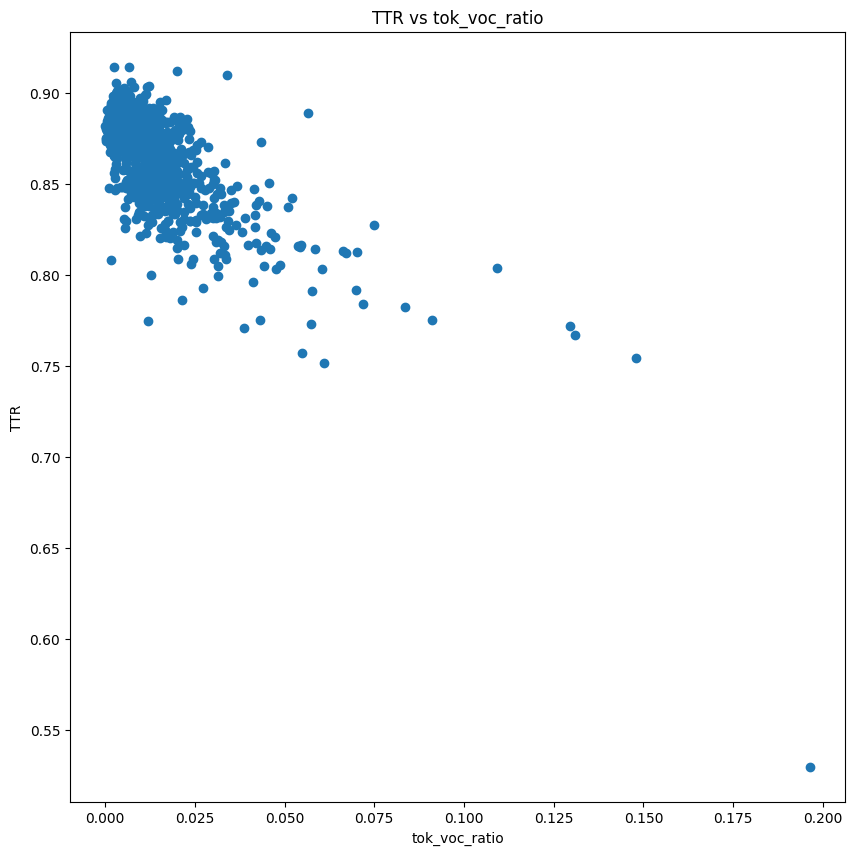

In [31]:
tup = [(val["tok_voc_ratio"], val["ttr"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))
plt.title("TTR vs tok_voc_ratio")
plt.xlabel("tok_voc_ratio")
plt.ylabel("TTR")

plt.scatter(*zip(*tup))

plt.show()

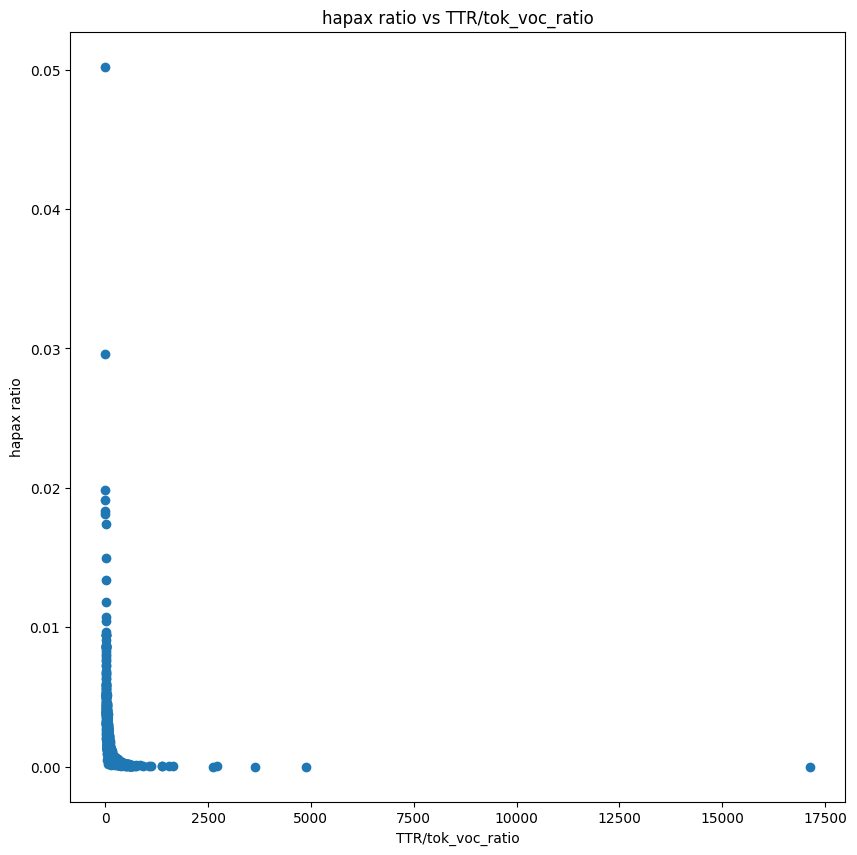

In [32]:
tup = [(val["ttr"]/ val["tok_voc_ratio"], val["hapax_ratio"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))

plt.title("hapax ratio vs TTR/tok_voc_ratio")

plt.xlabel("TTR/tok_voc_ratio")
plt.ylabel("hapax ratio")

plt.scatter(*zip(*tup))

plt.show()


In [33]:
tup = [(txt, val["ttr"]/ val["tok_voc_ratio"]) for txt, val in dict_stats.items()]

tup = sorted(tup, key=lambda x: x[1], reverse=True)

for txt, val in tup[:10]:
    print(f"{val:.3f} {txt}")

17127.000 Corpus/Mazarinades\3001-3100\Moreau3037_MAZ.xml
4886.760 Corpus/Mazarinades\1601-1700\Moreau1643_GBOOKS.xml
3631.760 Corpus/Mazarinades\3001-3100\Moreau3097_GBOOKS.xml
2723.286 Corpus/Mazarinades\601-700\Moreau667_GBOOKS.xml
2633.119 Corpus/Mazarinades\2501-2600\Moreau2574_GBOOKS.xml
1656.424 Corpus/Mazarinades\3601-3700\Moreau3634_GBOOKS.xml
1562.200 Corpus/Mazarinades\3001-3100\Moreau3035-iv_MAZ.xml
1393.717 Corpus/Mazarinades\3001-3100\Moreau3053-ii_MAZ.xml
1387.281 Corpus/Mazarinades\801-900\Moreau830_GBOOKS.xml
1123.010 Corpus/Mazarinades\101-200\Moreau119_GALL.xml


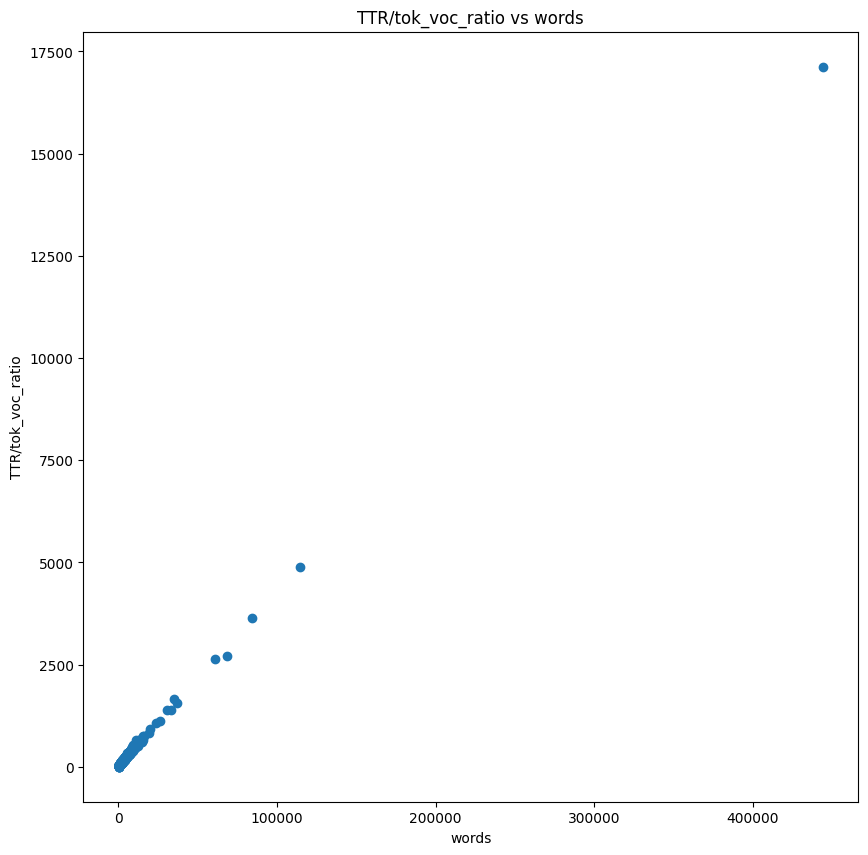

In [34]:
tup = [(val["words"], val["ttr"]/ val["tok_voc_ratio"]) for val in dict_stats.values()]

plt.figure(figsize=(10, 10))

plt.title("TTR/tok_voc_ratio vs words")

plt.xlabel("words")
plt.ylabel("TTR/tok_voc_ratio")

plt.scatter(*zip(*tup))

plt.show()

In [35]:
x = [val["header"]["change"]["@status"] if isinstance(val["header"]["change"], dict) else val["header"]["change"][0]["@status"] for val in dict_stats.values()]
len(x)/ len([e for e in x if e == "corrected"])

1.0

In [36]:
for txt, val in dict_stats.items():
    pprint(val["header"])
    break

{'change': {'@status': 'corrected', '@when': '2022-03-17', '@who': 'AB'},
 'dates': {'#text': '2 mars 2022',
           '@type': 'file_creation',
           '@when': '2022-03-02'},
 'form': 'prose',
 'genre': 'recueil',
 'handwritten_note': False,
 'illustration': False,
 'table_of_content': True,
 'titre': 'Recueil des pièces secrètes de ce temps.'}


In [37]:
val["tok_voc_ratio"]

0.0006349084192704325

prose: 0.013
('vers', 'prose'): 0.010
vers: 0.017


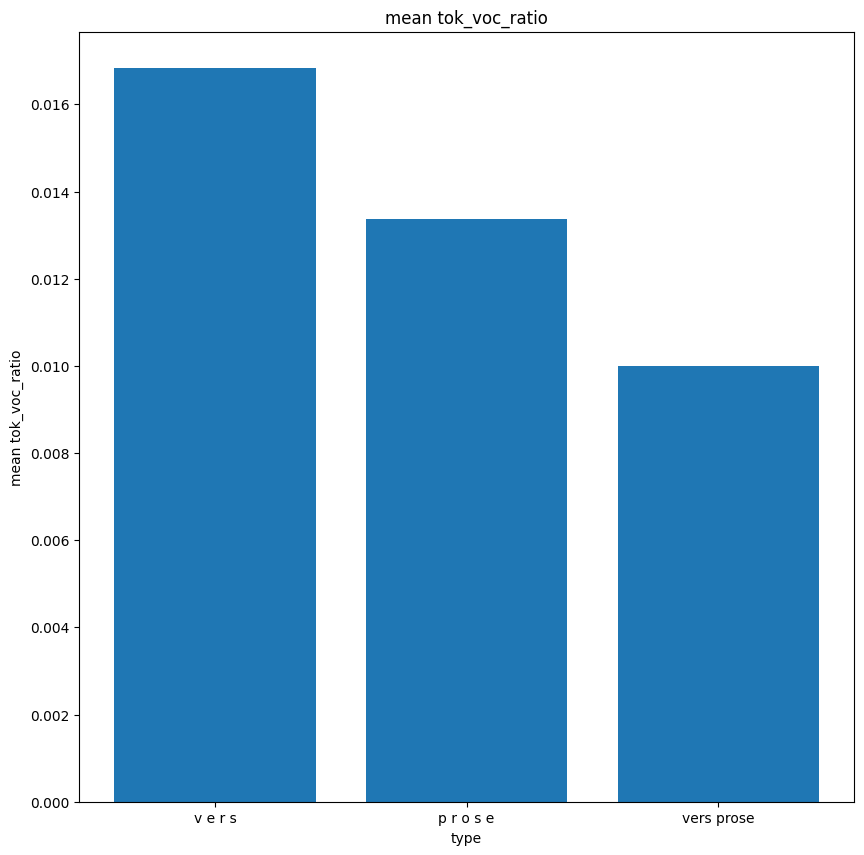

In [38]:
def stats(key):
    stats = {}
    for txt, val in dict_stats.items():
        type_ = val["header"]["form"] if isinstance(val["header"]["form"], str) else tuple(val["header"]["form"])

        if type_ not in stats:
            for e in stats.keys():
                if set(e) == set(type_):
                    type_ = e
                    break
            else:
                stats[type_] = []

        stats[type_].append(mean(val[key]))

    for k, v in stats.items():
        print(f"{k}: {mean(v):.3f}")

    plot = [(" ".join(k), mean(v)) for k, v in stats.items()]
    plot = sorted(plot, key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 10))
    plt.title(f"mean {key}")
    plt.xlabel("type")
    plt.ylabel(f"mean {key}")

    plt.bar(*zip(*plot))

    plt.show()

stats("tok_voc_ratio")

prose: 0.870
('vers', 'prose'): 0.867
vers: 0.844


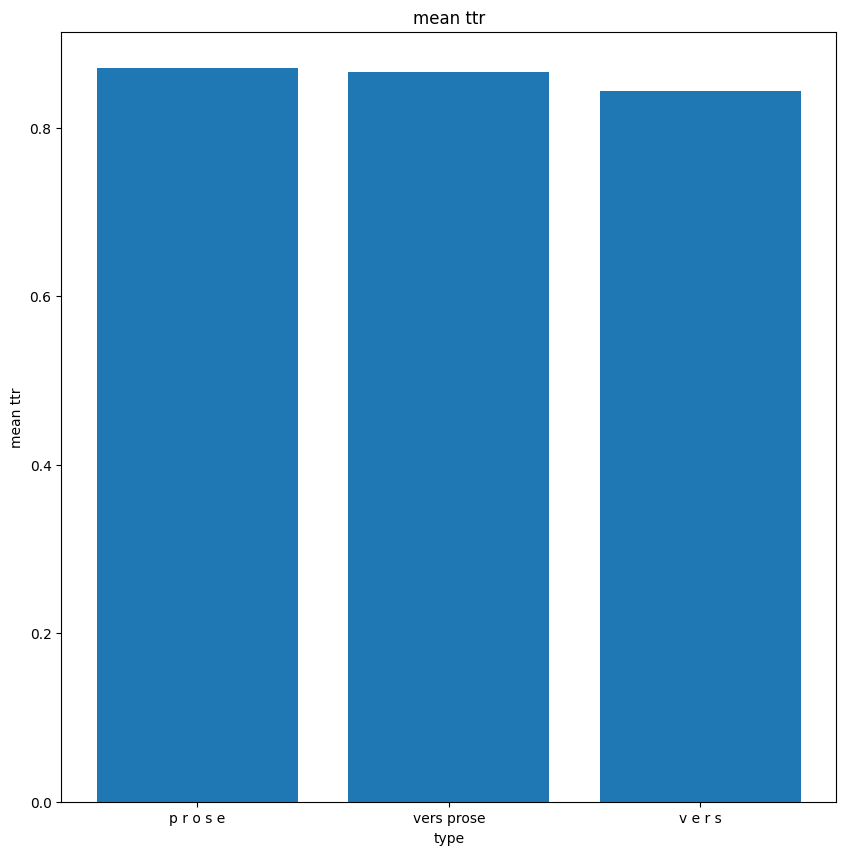

In [39]:
stats("ttr")


prose: 0.002
('vers', 'prose'): 0.001
vers: 0.002


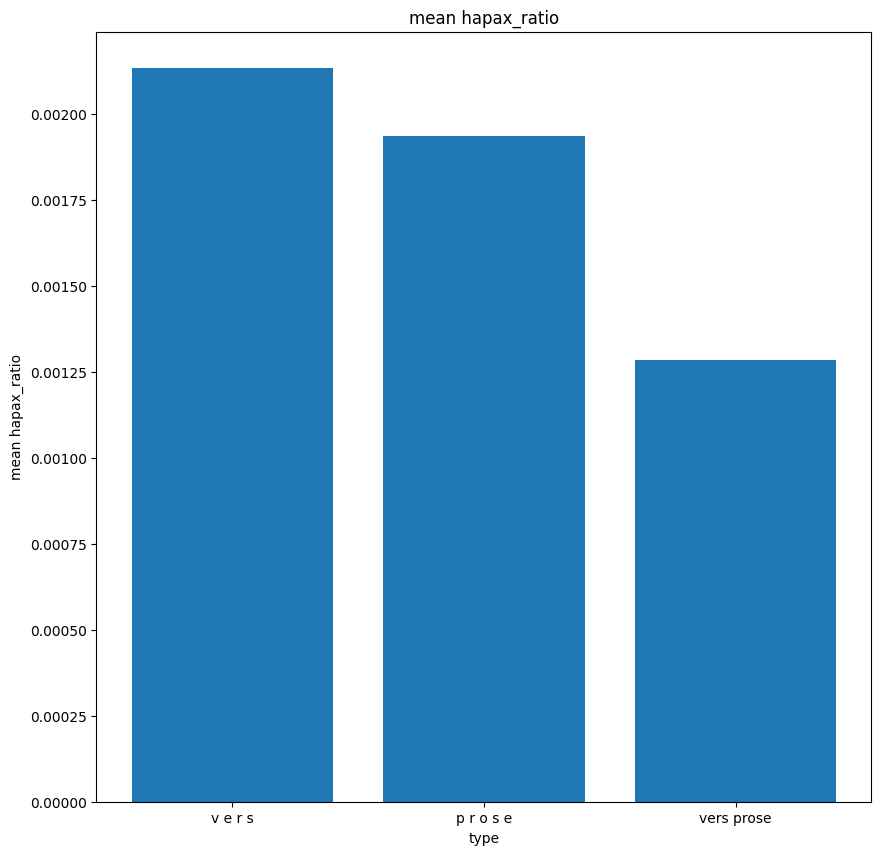

In [40]:
stats("hapax_ratio")

1649-02-19: 0.002
1651-02-28: 0.002
1649-04-01: 0.002
1649-01-13: 0.002
1652-08-19: 0.001
('vers', 'prose'): 0.002
1649-02-03: 0.002
1650-01-18: 0.003
1652-01-09: 0.002
1651-07-20: 0.002
1649-09-05: 0.001
1652-05-25: 0.002
1651-07-06: 0.002
1651-01-01: 0.002
1652-10-13: 0.001
1652-04-01: 0.002
1648-04: 0.002
1651-09-07: 0.002
1649-03-15: 0.002
1652-07-04: 0.001
1649-08-18: 0.002
1652-08-07: 0.002
1651-04-05: 0.002
1652-04-28: 0.001
1652-08-23: 0.002
1650-03-05: 0.002
1650-05-09: 0.001
1649-02-08: 0.001
00-00-0000: 0.002
1651-08-17: 0.002
1652-07-13: 0.001
1651-04-18: 0.001
1650-07-04: 0.003
1651-12-12: 0.003
1649-07-17: 0.001
1652-09-24: 0.001
1651-09-13: 0.000


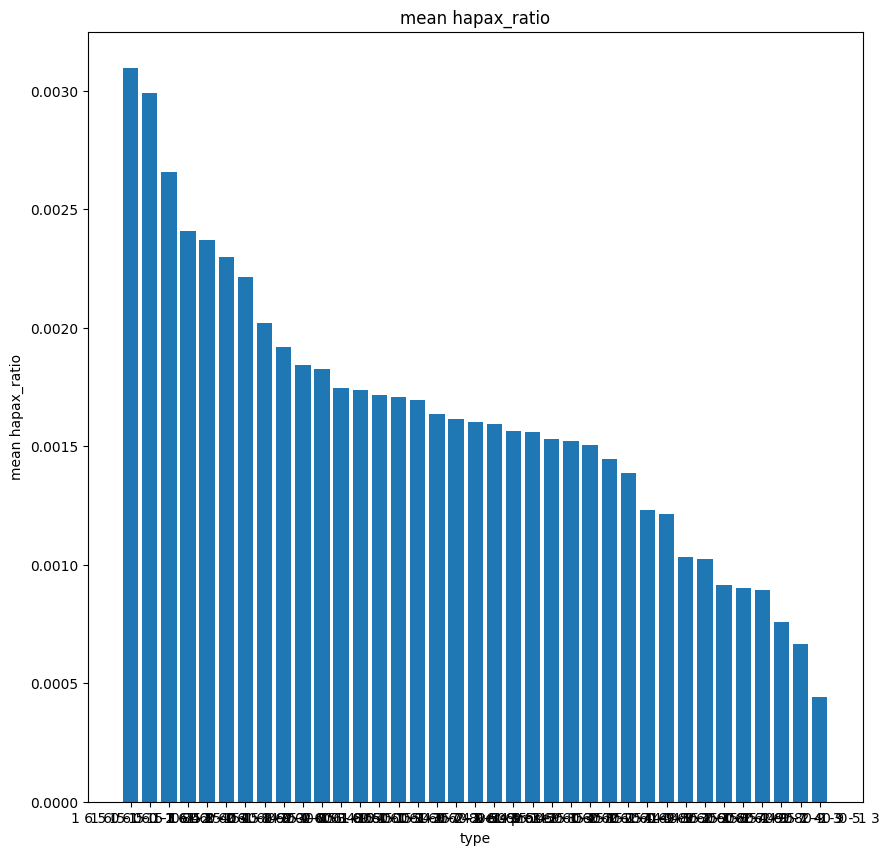

In [41]:
def stats2(header_prop, stats_prop):
    stats = {}
    for txt, val in dict_stats.items():
        if header_prop not in val["header"]:
            continue

        type_ = val["header"][header_prop] if isinstance(val["header"]["form"], str) else tuple(val["header"]["form"])


        if isinstance(type_, bool):
                type_ = str(type_)


        if type_ not in stats:
            for e in stats.keys():
                if set(e) == set(type_):
                    type_ = e
                    break
            else:
                stats[type_] = []

        stats[type_].append(mean(val[stats_prop]))

    for k, v in stats.items():
        print(f"{k}: {mean(v):.3f}")

    plot = [(" ".join(k), mean(v)) for k, v in stats.items()]
    plot = sorted(plot, key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 10))
    plt.title(f"mean {stats_prop}")
    plt.xlabel("type")
    plt.ylabel(f"mean {stats_prop}")

    plt.bar(*zip(*plot))

    plt.show()

stats2("creation", "hapax_ratio")

1649-02-19: 0.012
1651-02-28: 0.012
1649-04-01: 0.011
1649-01-13: 0.013
1652-08-19: 0.008
('vers', 'prose'): 0.012
1649-02-03: 0.012
1650-01-18: 0.021
1652-01-09: 0.014
1651-07-20: 0.014
1649-09-05: 0.006
1652-05-25: 0.012
1651-07-06: 0.011
1651-01-01: 0.017
1652-10-13: 0.009
1652-04-01: 0.013
1648-04: 0.015
1651-09-07: 0.012
1649-03-15: 0.011
1652-07-04: 0.009
1649-08-18: 0.015
1652-08-07: 0.010
1651-04-05: 0.011
1652-04-28: 0.010
1652-08-23: 0.015
1650-03-05: 0.014
1650-05-09: 0.009
1649-02-08: 0.008
00-00-0000: 0.013
1651-08-17: 0.011
1652-07-13: 0.006
1651-04-18: 0.007
1650-07-04: 0.017
1651-12-12: 0.021
1649-07-17: 0.010
1652-09-24: 0.008
1651-09-13: 0.004


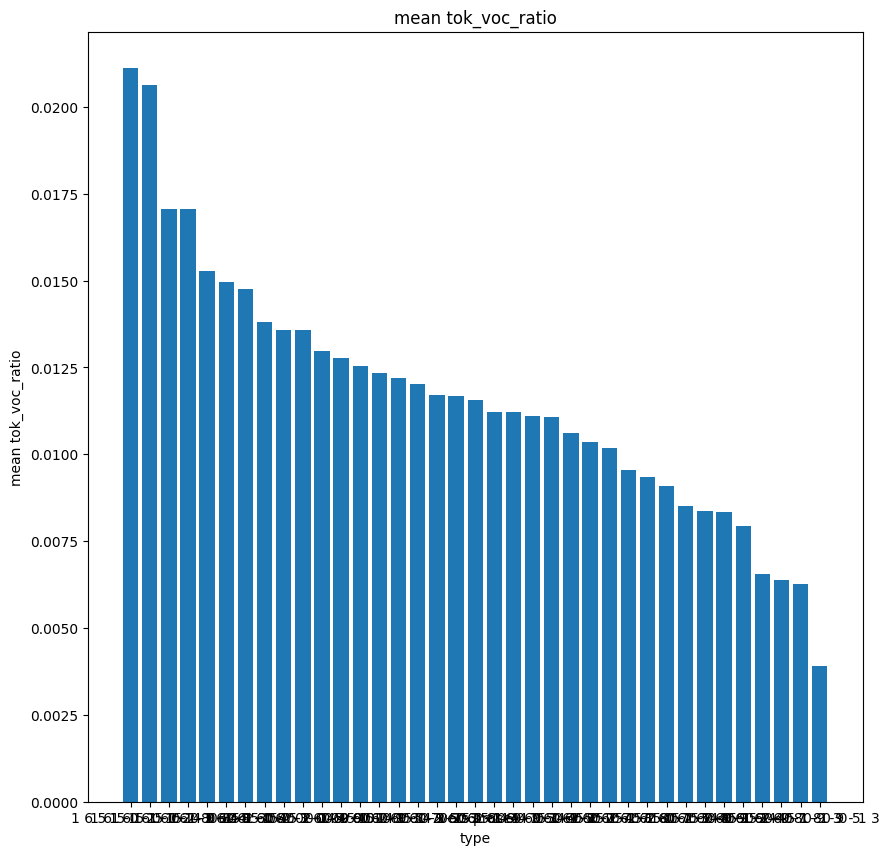

In [42]:
stats2("creation", "tok_voc_ratio")

True: 60792.429
False: 16656.728
('vers', 'prose'): 80385.053


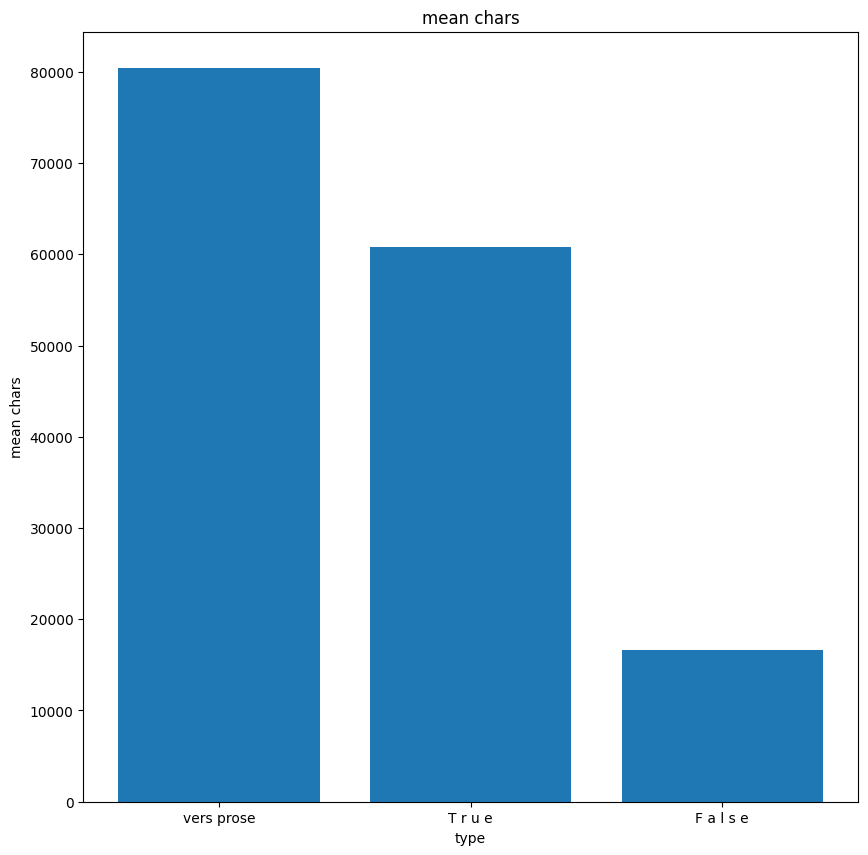

True: 0.003
False: 0.014
('vers', 'prose'): 0.010


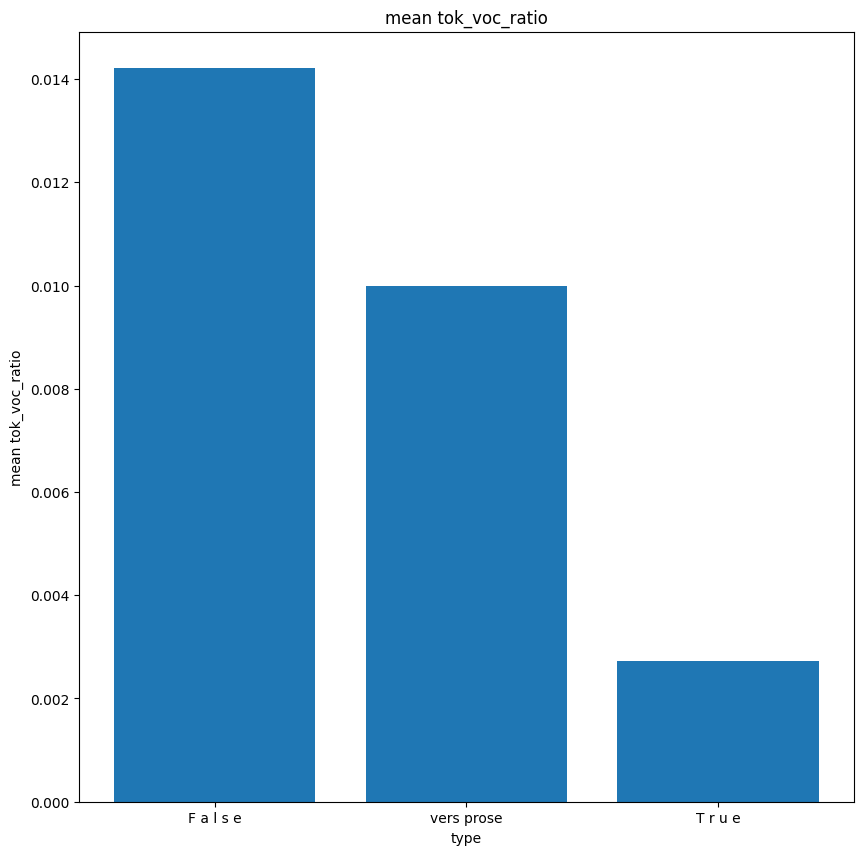

In [43]:
stats2("table_of_content", "chars")
stats2("table_of_content", "tok_voc_ratio")

In [44]:
for txt, val in dict_stats.items():
    pprint(val)
    break

{'chars': 185572,
 'hapax': 3,
 'hapax_ratio': 1.9239649068800985e-05,
 'header': {'change': {'@status': 'corrected',
                       '@when': '2022-03-17',
                       '@who': 'AB'},
            'dates': {'#text': '2 mars 2022',
                      '@type': 'file_creation',
                      '@when': '2022-03-02'},
            'form': 'prose',
            'genre': 'recueil',
            'handwritten_note': False,
            'illustration': False,
            'table_of_content': True,
            'titre': 'Recueil des pièces secrètes de ce temps.'},
 'lines': 3752,
 'pages': 84,
 'tok_voc_ratio': 0.0006349084192704325,
 'ttr': 0.8848827664050074,
 'ttrs': [0.09090909090909091,
          0.3135593220338983,
          0.26666666666666666,
          0.6036036036036037,
          0.5346062052505967,
          0.5282608695652173,
          0.5011547344110855,
          0.5224215246636771,
          0.5011494252873563,
          0.5146067415730337,
          0.573626